<a href="https://colab.research.google.com/github/rediahmds/eco-sort/blob/main/train/train_cnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Prepare dataset

In [2]:
!pip install kagglehub

### Download

In [3]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("techsash/waste-classification-data")

print("Path to dataset files:", path)

100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 427M/427M [00:03<00:00, 126MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/techsash/waste-classification-data/versions/1


### Copy Dataset

In [5]:
from pathlib import Path
import shutil
import random

def copy_n_files(src_dir, dst_dir, n, randomize=False):
    src_path = Path(src_dir)
    dst_path = Path(dst_dir)

    # Buat folder tujuan jika belum ada
    dst_path.mkdir(parents=True, exist_ok=True)

    # Ambil semua file dari direktori sumber
    all_files = [f for f in src_path.iterdir() if f.is_file()]

    # Pastikan n tidak lebih besar dari jumlah file
    n = min(n, len(all_files))

    # Tentukan file mana yang akan disalin
    if randomize:
        files_to_copy = random.sample(all_files, n)
    else:
        files_to_copy = sorted(all_files)[:n]

    # Copy file satu per satu
    for file in files_to_copy:
        shutil.copy(file, dst_path)
        print(f"Copied: {file.name}")

    print(f"\nTotal {n} files copied from '{src_dir}' to '{dst_dir}' (random: {randomize}).")



In [19]:
copy_n_files(f"{path}/DATASET/TRAIN/O", "./dataset/train/organic", 1000, randomize=True)
copy_n_files(f"{path}/DATASET/TRAIN/R", "./dataset/train/non_organic", 1000, randomize=True)

copy_n_files(f"{path}/DATASET/TEST/O", "./dataset/test/organic", 200, randomize=True) # 20%
copy_n_files(f"{path}/DATASET/TEST/R", "./dataset/test/non_organic", 200, randomize=True) # 20%

Copied: O_6635.jpg
Copied: O_12340.jpg
Copied: O_2132.jpg
Copied: O_10862.jpg
Copied: O_3184.jpg
Copied: O_12247.jpg
Copied: O_10692.jpg
Copied: O_5438.jpg
Copied: O_7480.jpg
Copied: O_2033.jpg
Copied: O_5565.jpg
Copied: O_8573.jpg
Copied: O_7755.jpg
Copied: O_8047.jpg
Copied: O_7667.jpg
Copied: O_10193.jpg
Copied: O_10309.jpg
Copied: O_5345.jpg
Copied: O_4131.jpg
Copied: O_10399.jpg
Copied: O_10668.jpg
Copied: O_10331.jpg
Copied: O_3139.jpg
Copied: O_5281.jpg
Copied: O_9277.jpg
Copied: O_12268.jpg
Copied: O_10219.jpg
Copied: O_12493.jpg
Copied: O_7270.jpg
Copied: O_7463.jpg
Copied: O_10491.jpg
Copied: O_5180.jpg
Copied: O_1874.jpg
Copied: O_1574.jpg
Copied: O_10105.jpg
Copied: O_3668.jpg
Copied: O_1010.jpg
Copied: O_8951.jpg
Copied: O_10497.jpg
Copied: O_8640.jpg
Copied: O_1054.jpg
Copied: O_10685.jpg
Copied: O_7424.jpg
Copied: O_9983.jpg
Copied: O_9788.jpg
Copied: O_8085.jpg
Copied: O_7889.jpg
Copied: O_698.jpg
Copied: O_1296.jpg
Copied: O_8159.jpg
Copied: O_291.jpg
Copied: O_12445.j

### Data Distribution checking

In [20]:
from collections import Counter
from torchvision.datasets import ImageFolder

train_dataset = ImageFolder("dataset/train")
label_counts = Counter([label for _, label in train_dataset])
print("Label mapping:", train_dataset.class_to_idx)
print("Distribusi kelas:", label_counts)

test_dataset = ImageFolder("dataset/test")
label_counts = Counter([label for _, label in test_dataset])
print("Distribusi kelas:", label_counts)


Label mapping: {'non_organic': 0, 'organic': 1}
Distribusi kelas: Counter({0: 1000, 1: 1000})
Distribusi kelas: Counter({0: 200, 1: 200})


## Training and Evaluation

In [1]:
!pip install torch torchvision matplotlib

   ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 363.4/363.4 MB 4.2 MB/s eta 0:00:00
   ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 13.8/13.8 MB 125.6 MB/s eta 0:00:00
   ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 24.6/24.6 MB 94.9 MB/s eta 0:00:00
   ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 883.7/883.7 kB 57.9 MB/s eta 0:00:00
   ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 664.8/664.8 MB 2.4 MB/s eta 0:00:00
   ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 211.5/211.5 MB 5.4 MB/s eta 0:00:00
   ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚

### Training Options

#### (1) Training with early stopping - Recommended

Label mapping: {'non_organic': 0, 'organic': 1}
Train distribusi: Counter({0: 1000, 1: 1000})
Val distribusi: Counter({0: 200, 1: 200})


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/20 - Train Acc: 0.8000 - Val Acc: 0.8450
üì¶ Best model disimpan.
Epoch 2/20 - Train Acc: 0.8450 - Val Acc: 0.8675
üì¶ Best model disimpan.
Epoch 3/20 - Train Acc: 0.8645 - Val Acc: 0.8700
üì¶ Best model disimpan.
Epoch 4/20 - Train Acc: 0.8890 - Val Acc: 0.8425
Epoch 5/20 - Train Acc: 0.8995 - Val Acc: 0.8800
üì¶ Best model disimpan.
Epoch 6/20 - Train Acc: 0.8945 - Val Acc: 0.8625
Epoch 7/20 - Train Acc: 0.8940 - Val Acc: 0.8675
Epoch 8/20 - Train Acc: 0.9075 - Val Acc: 0.8625
Epoch 9/20 - Train Acc: 0.9195 - Val Acc: 0.8925
üì¶ Best model disimpan.
Epoch 10/20 - Train Acc: 0.9425 - Val Acc: 0.8250
Epoch 11/20 - Train Acc: 0.9280 - Val Acc: 0.8250
Epoch 12/20 - Train Acc: 0.9305 - Val Acc: 0.9000
üì¶ Best model disimpan.
Epoch 13/20 - Train Acc: 0.9425 - Val Acc: 0.8975
Epoch 14/20 - Train Acc: 0.9480 - Val Acc: 0.8900
Epoch 15/20 - Train Acc: 0.9510 - Val Acc: 0.8625
Epoch 16/20 - Train Acc: 0.9610 - Val Acc: 0.8650
Epoch 17/20 - Train Acc: 0.9600 - Val Acc: 0.8800
Epo

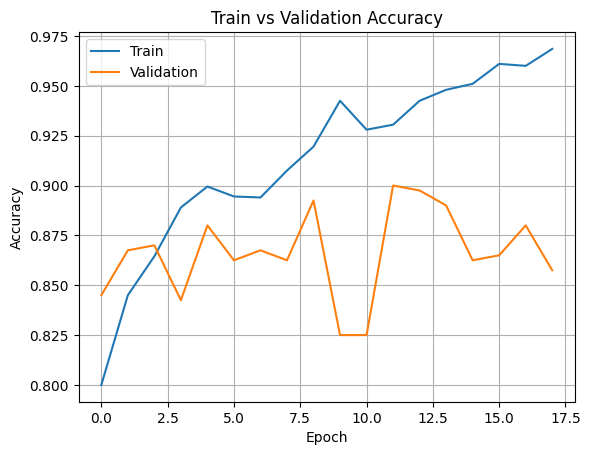

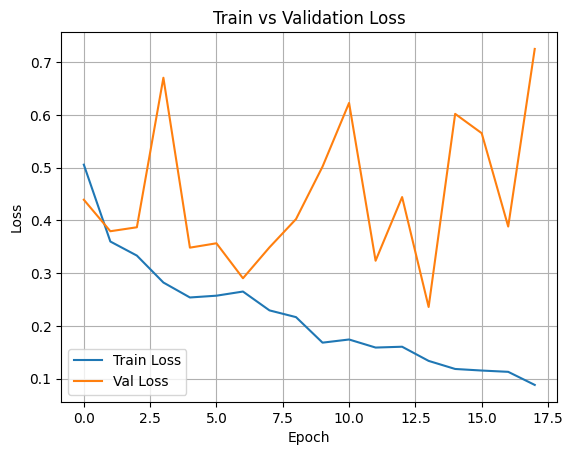

=== Classification Report ===
              precision    recall  f1-score   support

 non_organic       0.93      0.78      0.84       200
     organic       0.81      0.94      0.87       200

    accuracy                           0.86       400
   macro avg       0.87      0.86      0.86       400
weighted avg       0.87      0.86      0.86       400



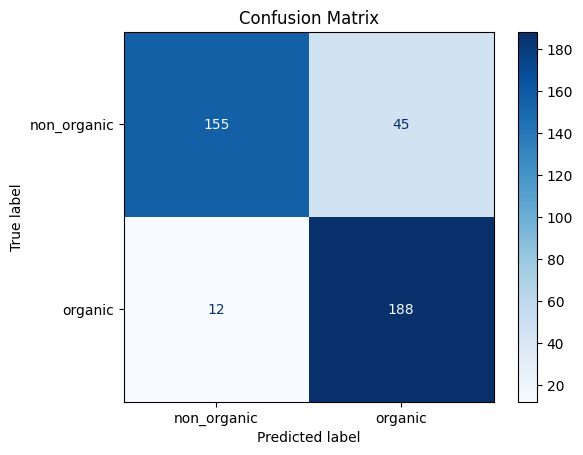

In [41]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from collections import Counter

# üîÅ Transformasi
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

# üìÅ Load dataset
train_dataset = datasets.ImageFolder("dataset/train", transform=transform)
val_dataset = datasets.ImageFolder("dataset/test", transform=transform)
class_names = train_dataset.classes
print("Label mapping:", train_dataset.class_to_idx)
print("Train distribusi:", Counter([label for _, label in train_dataset]))
print("Val distribusi:", Counter([label for _, label in val_dataset]))

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16)

# ‚öôÔ∏è Model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = models.resnet18(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, len(class_names))
model = model.to(device)

# üéØ Loss & optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# üîÅ Training loop
epochs = 20
patience = 6
train_accs, val_accs = [], []
train_losses, val_losses = [], []
best_val_acc = 0
early_stop_counter = 0

for epoch in range(epochs):
    model.train()
    train_loss = 0
    correct, total = 0, 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        correct += torch.sum(preds == labels)
        total += labels.size(0)

    train_acc = correct / total
    train_accs.append(train_acc.item())
    train_losses.append(train_loss / len(train_loader))

    # üîç Validasi
    model.eval()
    val_loss = 0
    correct, total = 0, 0
    y_true, y_pred = [], []

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            val_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            correct += torch.sum(preds == labels)
            total += labels.size(0)

            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())

    val_acc = correct / total
    val_accs.append(val_acc.item())
    val_losses.append(val_loss / len(val_loader))

    print(f"Epoch {epoch+1}/{epochs} - Train Acc: {train_acc:.4f} - Val Acc: {val_acc:.4f}")

    # üíæ Simpan model terbaik
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        early_stop_counter = 0
        torch.save(model.state_dict(), "best_model.pt")
        print("üì¶ Best model disimpan.")
    else:
        early_stop_counter += 1
        if early_stop_counter >= patience:
            print("‚èπÔ∏è Early stopping triggered.")
            break

# üìä Grafik Accuracy
plt.plot(train_accs, label="Train")
plt.plot(val_accs, label="Validation")
plt.title("Train vs Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.show()

# üìâ Grafik Loss
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Val Loss")
plt.title("Train vs Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()

# üìë Classification Report
print("=== Classification Report ===")
print(classification_report(y_true, y_pred, target_names=class_names))

# üî∑ Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap="Blues")
plt.title("Confusion Matrix")
plt.grid(False)
plt.show()


#### (2) Training without early stopping

In [47]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms, models
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from collections import Counter
import time

# Transform
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

# Dataset
train_dataset = datasets.ImageFolder("dataset/train", transform=transform)
class_names = train_dataset.classes
print("Label mapping:", train_dataset.class_to_idx)
print("Distribusi:", Counter([label for _, label in train_dataset]))

val_dataset = datasets.ImageFolder("dataset/test", transform=transform)
print("Label mapping:", val_dataset.class_to_idx)
print("Distribusi:", Counter([label for _, label in val_dataset]))

# Split
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16)

# Model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = models.resnet18(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, len(class_names))
model = model.to(device)

# Loss & Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Training
epochs = 6
train_accs, val_accs = [], []
best_val_acc = 0

for epoch in range(epochs):
    model.train()
    correct, total, loss_total = 0, 0, 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()

        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        loss_total += loss.item()
        _, preds = torch.max(outputs, 1)
        correct += torch.sum(preds == labels)
        total += labels.size(0)

    train_acc = correct / total
    train_accs.append(train_acc.item())
    print(f"Epoch {epoch+1}/{epochs} - Train Acc: {train_acc:.4f}")

    # Validasi
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            correct += torch.sum(preds == labels)
            total += labels.size(0)

    val_acc = correct / total
    val_accs.append(val_acc.item())
    print(f"            ‚Üí Val Acc: {val_acc:.4f}")

# Simpan
torch.save(model.state_dict(), "model_cnn.pt")
print("‚úÖ Model disimpan.")

Label mapping: {'non_organic': 0, 'organic': 1}
Distribusi: Counter({0: 1000, 1: 1000})
Label mapping: {'non_organic': 0, 'organic': 1}
Distribusi: Counter({0: 200, 1: 200})


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/6 - Train Acc: 0.7750
            ‚Üí Val Acc: 0.8850
Epoch 2/6 - Train Acc: 0.8655
            ‚Üí Val Acc: 0.8750
Epoch 3/6 - Train Acc: 0.8725
            ‚Üí Val Acc: 0.8950
Epoch 4/6 - Train Acc: 0.8720
            ‚Üí Val Acc: 0.8600
Epoch 5/6 - Train Acc: 0.8730
            ‚Üí Val Acc: 0.8975
Epoch 6/6 - Train Acc: 0.8915
            ‚Üí Val Acc: 0.9175
‚úÖ Model disimpan.


### Evaluation


=== Classification Report ===
              precision    recall  f1-score   support

 non_organic       0.94      0.89      0.92       200
     organic       0.90      0.94      0.92       200

    accuracy                           0.92       400
   macro avg       0.92      0.92      0.92       400
weighted avg       0.92      0.92      0.92       400



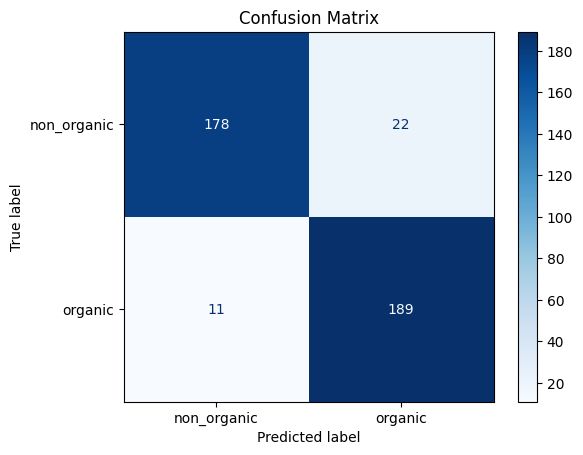

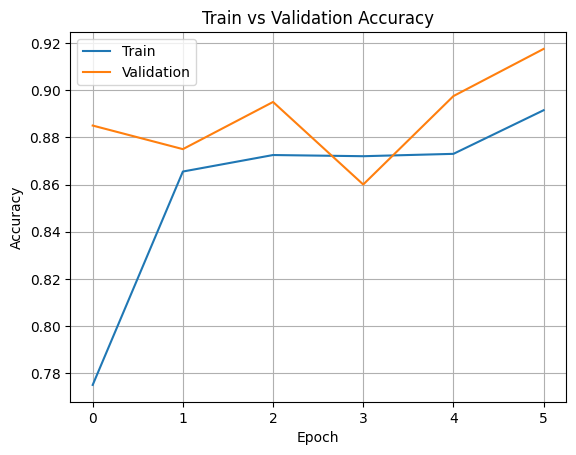

In [48]:
# üìä Evaluasi dengan laporan & Confusion Matrix
model.eval()
y_true, y_pred = [], []

for images, labels in val_loader:
    images = images.to(device)
    outputs = model(images)
    _, preds = torch.max(outputs, 1)

    y_true.extend(labels.numpy())
    y_pred.extend(preds.cpu().numpy())

print("\n=== Classification Report ===")
print(classification_report(y_true, y_pred, target_names=class_names))

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap="Blues")
plt.title("Confusion Matrix")
plt.show()

# Plot akurasi training & val
plt.plot(train_accs, label="Train")
plt.plot(val_accs, label="Validation")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.title("Train vs Validation Accuracy")
plt.legend()
plt.grid(True)
plt.show()